# Simple Modelling
We are going to try a real simple time series prediction on this one. 

## load the data
And check if everything is fine...

In [23]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense

print(tf.__version__)

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# read csv
data = pd.read_pickle("../../datasets/All.pickle")
data.index = pd.DatetimeIndex(data.DateTime)
data.head()

2.8.0-rc0


,NO2-ug-per-m3,Cars-Direction-1,Cars-Direction-2,Cars-Total,Day-Of-Week,Monday,Tuesday,Wednesday,Thursday,Friday,...,Number of vessels,DateTime,DaySin,DayCos,WeekSin,WeekCos,MonthSin,MonthCos,YearSin,YearCos
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,19.0,36,62,98,2,0,1,0,0,0,...,6,2019-01-01 00:00:00,0.000000,1.000000,0.781831,0.62349,0.201299,0.97953,0.017213,0.999852
2019-01-01 01:00:00,11.0,109,112,221,2,0,1,0,0,0,...,4,2019-01-01 01:00:00,0.258819,0.965926,0.781831,0.62349,0.201299,0.97953,0.017213,0.999852
2019-01-01 02:00:00,9.0,97,60,157,2,0,1,0,0,0,...,2,2019-01-01 02:00:00,0.500000,0.866025,0.781831,0.62349,0.201299,0.97953,0.017213,0.999852
2019-01-01 03:00:00,7.0,60,44,104,2,0,1,0,0,0,...,4,2019-01-01 03:00:00,0.707107,0.707107,0.781831,0.62349,0.201299,0.97953,0.017213,0.999852
2019-01-01 04:00:00,8.0,44,33,77,2,0,1,0,0,0,...,3,2019-01-01 04:00:00,0.866025,0.500000,0.781831,0.62349,0.201299,0.97953,0.017213,0.999852


## Input parameters
For Input, Cars-Total is expected to be the singe most important factor. Other parameters are day of week, wether it is a school holyday, some weather data, price of diesel fuel, number of vessels in the channel and the time of day. Labels are the amount of NO2 in ug per m³. 

## Split the data and normalize using training set 

Use 70%, 20% and 10% for training, validation and test sets.Data is not shuffled, since we are dealing with a time series where order is important. 

For the normalization, only the training dataset is used. It does not make sense to normalize all input data. some are one-hot encoded anyway or sin-cos encoded. No normalization for now. 

In [25]:
# select columns for X and Y
data_X = data[["Cars-Total", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday", "SchoolHoliday", "wind_meters_per_second", "rain_millimeters", "did_it_rain", "air_temp_deg_c", "relative_humidity_percent", "diesel", "Number of vessels", "DaySin", "DayCos"]]
data_Y = data[["NO2-ug-per-m3"]]
print(data_X.shape)

#print(data_X.max())

# normalize data
#data_mean = data.mean()
#data_std = data.std()

#print(data_mean.head)
#print(data_std.head)

# split data
n = len(data)
# print(n)
train_data_X = data_X[0:int(n*0.7)]
val_data_X = data_X[int(n*0.7):int(n*0.9)]
test_data_X = data_X[int(n*0.9):]

train_labels = data_Y[0:int(n*0.7)]
val_labels = data_Y[int(n*0.7):int(n*0.9)]
test_labels = data_Y[int(n*0.9):]

(8052, 18)


## Simple model
This very simple model takes the X-values as input and the Y-values as labels. In other words, it tries to predict the pollution from the given parameters. I don't think this will be of much use to anyone, but here we go...

In [82]:
model = tf.keras.models.Sequential([
    Dense(16, activation="relu", kernel_regularizer='l2', input_shape=(None, len(train_data_X.columns))), 
    Dense(8, activation="relu", kernel_regularizer='l2'), 
    Dense(8, activation="relu", kernel_regularizer='l2'), 
    #Dense(8, activation="relu", kernel_regularizer='l2'), 
    Dense(1, kernel_regularizer='l2', activation="linear")
])

model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, None, 16)          304       
                                                                 
 dense_46 (Dense)            (None, None, 8)           136       
                                                                 
 dense_47 (Dense)            (None, None, 8)           72        
                                                                 
 dense_48 (Dense)            (None, None, 1)           9         
                                                                 
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


In [83]:
history = model.fit(train_data_X, train_labels, batch_size=32, epochs=50, validation_data=(val_data_X, val_labels))

Epoch 1/50
177/177 [==============================] - 1s 3ms/step - loss: 962.0205 - mean_absolute_error: 24.9920 - val_loss: 411.5440 - val_mean_absolute_error: 16.5549
Epoch 2/50
177/177 [==============================] - 0s 2ms/step - loss: 499.3513 - mean_absolute_error: 18.2458 - val_loss: 386.3275 - val_mean_absolute_error: 16.3855
Epoch 3/50
177/177 [==============================] - 0s 2ms/step - loss: 472.5992 - mean_absolute_error: 18.0050 - val_loss: 395.6570 - val_mean_absolute_error: 16.5839
Epoch 4/50
177/177 [==============================] - 0s 2ms/step - loss: 471.1330 - mean_absolute_error: 17.9706 - val_loss: 375.3301 - val_mean_absolute_error: 16.1734
Epoch 5/50
177/177 [==============================] - 0s 2ms/step - loss: 461.2959 - mean_absolute_error: 17.8463 - val_loss: 376.1017 - val_mean_absolute_error: 16.2172
Epoch 6/50
177/177 [==============================] - 0s 2ms/step - loss: 460.3906 - mean_absolute_error: 17.8028 - val_loss: 376.5166 - val_mean_abso

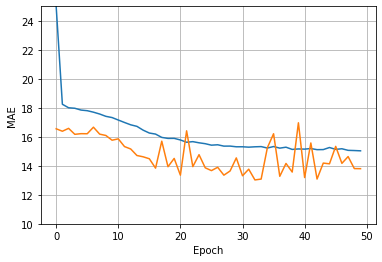

In [84]:
x = history.epoch
train_mae = history.history["mean_absolute_error"]
val_mae = history.history["val_mean_absolute_error"]

plt.plot(x, train_mae, x, val_mae)
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.ylim(10, 25)
plt.grid()

In [85]:
test_loss, test_acc = model.evaluate(test_data_X, test_labels)

print("\ntest loss and test accuracy are: " + str(test_loss) + " and " + str(test_acc))

26/26 [==============================] - 0s 2ms/step - loss: 234.6336 - mean_absolute_error: 12.6662

test loss and test accuracy are: 234.63360595703125 and 12.666182518005371
